---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib as plt
%matplotlib inline
from pdb import set_trace
from scipy.signal import argrelextrema

# Assignment 4 - Hypothesis Testing
This assignment requires more individual learning than previous assignments - you are encouraged to check out the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/) to find functions or methods you might not have used yet, or ask questions on [Stack Overflow](http://stackoverflow.com/) and tag them as pandas and python related. And of course, the discussion forums are open for interaction with your peers and the course staff.

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.

**Hypothesis**: University towns have their mean housing prices less effected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

The following data files are available for this assignment:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, only look at GDP data from the first quarter of 2000 onward.

Each function in this assignment below is worth 10%, with the exception of ```run_ttest()```, which is worth 50%.

In [2]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [3]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format of the DataFrame should be:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )
    
    The following cleaning needs to be done:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. Depending on how you read the data, you may need to remove newline character '\n'. '''
    Un_sity= pd.read_table('university_towns.txt', header=None)
    tmp = ''
    deldubl= False
    Un_sity[1] = [0 for i in range(len(Un_sity))]
    for i in range(len(Un_sity)):
        if '[edit]' in Un_sity.iloc[i,0]:
             tmp= Un_sity.iloc[i,0].split('[')[0]        
        Un_sity.iloc[i,1] = tmp
        if '(' in Un_sity.iloc[i,0]:
            Un_sity.iloc[i,0] = Un_sity.iloc[i,0].split('(')[0]

    Un_sity.columns = ["RegionName","State"]
    Un_sity = Un_sity.set_index('State')
    Un_sity = Un_sity[Un_sity.RegionName.str.contains('[edit]') == False] 
    return Un_sity

get_list_of_university_towns()

,RegionName
State,
Alabama,Auburn
Alabama,Troy
Alabama,Tuscaloosa
Arizona,Tucson
Arkansas,Conway
California,Pomona
California,Turlock
Colorado,Alamosa
Colorado,Durango


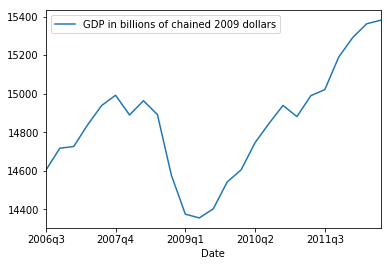

In [4]:
gdplev = pd.read_excel('gdplev.xls',skiprows=5)
gdplev_year = gdplev.loc[:,'Unnamed: 0':'GDP in billions of chained 2009 dollars']
gdplev_year.columns = ['Date','GDP in billions of current dollars','GDP in billions of chained 2009 dollars']

gdplev_year.dropna(axis=0, how='all',inplace=True)   
gdplev_year['Date'] = (gdplev_year['Date'].astype(str).apply(lambda x: pd.to_datetime(x, format='%Y.0'))
                       .apply(lambda x: x.year))

gdplev_quart = gdplev.loc[:,'Unnamed: 4':'GDP in billions of chained 2009 dollars.1']
gdplev_quart.dropna(axis=0, how='all',inplace=True)
gdplev_quart.columns = ['Date','GDP in billions of current dollars','GDP in billions of chained 2009 dollars']

gdplev_quart = gdplev_quart.set_index('Date')
gdplev_quart.drop(gdplev_quart.index[:-66], inplace=True)
#qw_ind = pd.Series(gdplev_quart.index)
qw_ind = list(gdplev_quart.index)
gdplev_quart_ress = gdplev_quart.iloc[-40:-15]
gdplev_quart_ress.plot(y='GDP in billions of chained 2009 dollars', kind='line')

In [5]:
qw_ind

['2000q1',
 '2000q2',
 '2000q3',
 '2000q4',
 '2001q1',
 '2001q2',
 '2001q3',
 '2001q4',
 '2002q1',
 '2002q2',
 '2002q3',
 '2002q4',
 '2003q1',
 '2003q2',
 '2003q3',
 '2003q4',
 '2004q1',
 '2004q2',
 '2004q3',
 '2004q4',
 '2005q1',
 '2005q2',
 '2005q3',
 '2005q4',
 '2006q1',
 '2006q2',
 '2006q3',
 '2006q4',
 '2007q1',
 '2007q2',
 '2007q3',
 '2007q4',
 '2008q1',
 '2008q2',
 '2008q3',
 '2008q4',
 '2009q1',
 '2009q2',
 '2009q3',
 '2009q4',
 '2010q1',
 '2010q2',
 '2010q3',
 '2010q4',
 '2011q1',
 '2011q2',
 '2011q3',
 '2011q4',
 '2012q1',
 '2012q2',
 '2012q3',
 '2012q4',
 '2013q1',
 '2013q2',
 '2013q3',
 '2013q4',
 '2014q1',
 '2014q2',
 '2014q3',
 '2014q4',
 '2015q1',
 '2015q2',
 '2015q3',
 '2015q4',
 '2016q1',
 '2016q2']

In [6]:
def get_recession_start():
    '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3'''    
    x = argrelextrema(gdplev_quart['GDP in billions of chained 2009 dollars'].values,np.less)
    return gdplev_quart.index.values[x[0][2]]

get_recession_start()

'2008q1'

In [7]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''
    x = argrelextrema(gdplev_quart['GDP in billions of chained 2009 dollars'].values,np.greater)
    return gdplev_quart.index.values[x[0][4]]
get_recession_end()

'2010q4'

In [8]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time as a 
    string value in a format such as 2005q3'''
    x = argrelextrema(gdplev_quart['GDP in billions of chained 2009 dollars'].values,np.less)
    return gdplev_quart.index.values[x[0][3]]
get_recession_bottom()

'2009q2'

In [19]:
City_Zhvi= pd.read_csv('City_Zhvi_AllHomes.csv')
City_Zhvi['State'] = City_Zhvi['State'].map(states)
City_Zhvi = City_Zhvi.set_index(['State','RegionName']).iloc[:,-200:]
City_Zhvi_qw = pd.DataFrame(index=City_Zhvi.index,columns=qw_ind)

City_t = City_Zhvi.T
City_t.index = City_t.index.map(lambda x: x.split('-')[0])
i=0
for group, frame in City_t.groupby(level=0):
    if group != '2016':
        df1, df2, df3, df4 = np.array_split(frame, 4)
        City_Zhvi_qw[qw_ind[i]] =df1.mean(axis=0)
        City_Zhvi_qw[qw_ind[i+1]] =df2.mean(axis=0)
        City_Zhvi_qw[qw_ind[i+2]] =df3.mean(axis=0)
        City_Zhvi_qw[qw_ind[i+3]] =df4.mean(axis=0)
        i+=4
        #set_trace()

    else:
        df1, df2 = np.array_split(frame[:-2], 2)
        df3 = frame.iloc[-1]
        City_Zhvi_qw[qw_ind[i]] =df1.mean(axis=0)
        #set_trace()
        City_Zhvi_qw[qw_ind[i+1]] =df2.mean(axis=0)
        #City_Zhvi_qw[qw_ind[i+2]] =df3.mean(axis=0)
        
City_Zhvi_qw

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,...,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.031333e+05,5.154667e+05,5.228000e+05,5.280667e+05,5.322667e+05,5.408000e+05,5.572000e+05,5.728333e+05,5.828667e+05,5.916333e+05
California,Los Angeles,2.070667e+05,2.144667e+05,2.209667e+05,2.261667e+05,2.330000e+05,2.391000e+05,2.450667e+05,2.530333e+05,2.619667e+05,2.727000e+05,...,4.842667e+05,4.980333e+05,5.090667e+05,5.188667e+05,5.288000e+05,5.381667e+05,5.472667e+05,5.577333e+05,5.660333e+05,5.774667e+05
Illinois,Chicago,1.384000e+05,1.436333e+05,1.478667e+05,1.521333e+05,1.569333e+05,1.618000e+05,1.664000e+05,1.704333e+05,1.755000e+05,1.775667e+05,...,1.909000e+05,1.926333e+05,1.957667e+05,2.012667e+05,2.010667e+05,2.060333e+05,2.083000e+05,2.079000e+05,2.060667e+05,2.082000e+05
Pennsylvania,Philadelphia,5.300000e+04,5.363333e+04,5.413333e+04,5.470000e+04,5.533333e+04,5.553333e+04,5.626667e+04,5.753333e+04,5.913333e+04,6.073333e+04,...,1.137333e+05,1.137333e+05,1.153000e+05,1.156667e+05,1.162000e+05,1.179667e+05,1.212333e+05,1.222000e+05,1.234333e+05,1.269333e+05
Arizona,Phoenix,1.118333e+05,1.143667e+05,1.160000e+05,1.174000e+05,1.196000e+05,1.215667e+05,1.227000e+05,1.243000e+05,1.265333e+05,1.283667e+05,...,1.632333e+05,1.642667e+05,1.653667e+05,1.685000e+05,1.715333e+05,1.741667e+05,1.790667e+05,1.838333e+05,1.879000e+05,1.914333e+05
Nevada,Las Vegas,1.326000e+05,1.343667e+05,1.354000e+05,1.370000e+05,1.395333e+05,1.417333e+05,1.433667e+05,1.461333e+05,1.493333e+05,1.509333e+05,...,1.660000e+05,1.700667e+05,1.734000e+05,1.754667e+05,1.775000e+05,1.816000e+05,1.867667e+05,1.906333e+05,1.946000e+05,1.972000e+05
California,San Diego,2.229000e+05,2.343667e+05,2.454333e+05,2.560333e+05,2.672000e+05,2.762667e+05,2.845000e+05,2.919333e+05,3.012333e+05,3.128667e+05,...,4.740000e+05,4.802000e+05,4.890333e+05,4.964333e+05,5.033667e+05,5.120667e+05,5.197667e+05,5.254667e+05,5.293333e+05,5.362333e+05
Texas,Dallas,8.446667e+04,8.386667e+04,8.486667e+04,8.783333e+04,8.973333e+04,8.930000e+04,8.906667e+04,9.090000e+04,9.256667e+04,9.380000e+04,...,1.053333e+05,1.066333e+05,1.089000e+05,1.115333e+05,1.137000e+05,1.211333e+05,1.285667e+05,1.346000e+05,1.405000e+05,1.446000e+05
California,San Jose,3.742667e+05,4.065667e+05,4.318667e+05,4.555000e+05,4.706667e+05,4.702000e+05,4.568000e+05,4.455667e+05,4.414333e+05,4.577667e+05,...,6.611667e+05,6.794000e+05,6.970333e+05,7.149333e+05,7.314333e+05,7.567333e+05,7.764000e+05,7.891333e+05,8.036000e+05,8.189333e+05


In [10]:
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. This dataframe should be a dataframe with
    columns for 2000q1 through 2016q3, and should have a multi-index
    in the shape of ["State","RegionName"].
    
    Note: Quarters are defined in the assignment descraiption, they are
    not arbitrary three month periods.
    
    The resulting dataframe should have 67 columns, and 10,730 rows.
    '''
    
    return "ANSWER"

In [11]:
def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Return the tuple (different, p, better) where different=True if the t-test is
    True at a p<0.01 (we reject the null hypothesis), or different=False if 
    otherwise (we cannot reject the null hypothesis). The variable p should
    be equal to the exact p value returned from scipy.stats.ttest_ind(). The
    value for better should be either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).'''
    
    return "ANSWER"